In [1]:
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
# from IPython.display import display, HTML

from pykat import finesse                  
from pykat.commands import *              


pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# base model on which to make changes
basekat = finesse.kat()
basekat.verbose = False

In [3]:
basecode = """
l laser 1 0 n0   # Laser (Power = 1 W, wavelength offset = 0)
s s1 1 n0 nc1    # Space (Length = 1 m)

# the cavity
m m1 0.7 0.3 0 nc1 nc2  # Mirror  (R = 0.7, T = 0.3, phi = 0)
s sL 4000 nc2 nc3       # Space (Length = 4 km)
m m2 0.8 0.2 0 nc3 nc4  # Mirror  (R = 0.8, T = 0.2, phi = 0)

# detectors
pd circ nc2
pd tran nc4
pd refl nc1
"""

basekat.parse(basecode)

In [4]:
print(basekat.components,basekat.detectors,basekat.commands,sep='\n')

{'laser': <pykat.components.laser_1 (laser) at 0x7fc8ccb60f98>, 's1': <pykat.components.space_2 (s1) at 0x7fc8ccaef1d0>, 'm1': <pykat.components.mirror_3 (m1) at 0x7fc8ccaef400>, 'sL': <pykat.components.space_4 (sL) at 0x7fc8ccaefba8>, 'm2': <pykat.components.mirror_5 (m2) at 0x7fc8ccaeff60>}
{'circ': <pykat.detectors.pykat.detectors.pd_1 object at 0x7fc8ccafc710>, 'tran': <pykat.detectors.pykat.detectors.pd_2 object at 0x7fc8ccafca58>, 'refl': <pykat.detectors.pykat.detectors.pd_3 object at 0x7fc8ccafcda0>}
{}


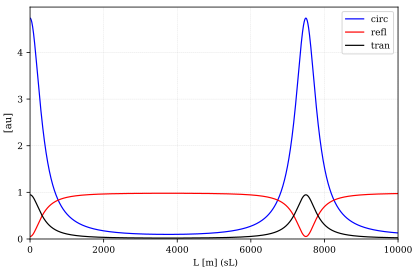

In [5]:
# laser offset frequency
kat1 = deepcopy(basekat)
kat1.laser.f = 2e4
kat1code = """
xaxis sL L lin 0 10k 2000
# yaxis abs
"""

kat1.parse(kat1code)
out1 = kat1.run()
out1.plot(ylim=(0,None))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:20: UserWarning: parseKatCode depreciated, use parse.


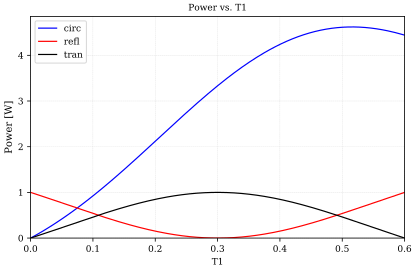

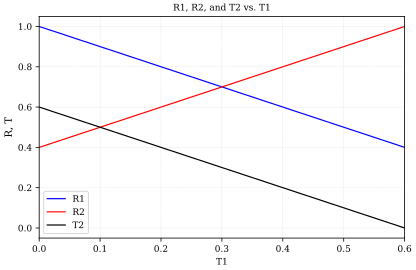

In [6]:
# changing T1, fixing T1 + T2
kat1 = deepcopy(basekat)

code = """
## Simulation instructions ##
xaxis m1 T lin 0 0.6 200   # Varying transmittance of input mirror m1.
yaxis abs                  # Plotting the amplitude of the detector measurements. 

## Functions computing reflectance and transmittance ##
func R1 = 1-$x1             # Reflectance of m1 (lossless)
func T2 = 0.6 - $x1         # Transmittance of m2 (T1 + T2 = 0.6)
func R2 = 1-$T2             # Reflectance of m2

## Setting values ## 
put m1 R $R1                # Setting reflectance of m1 to R1
put m2 T $T2                # Setting transmittance of m2 to T2
put m2 R $R2                # Setting reflectance of m2 to R2
"""

kat1.parseKatCode(code) # Parsing the FINESSE-code
out1 = kat1.run() 

fig1a = out1.plot(detectors=['refl','circ','tran'], 
                  xlabel='T1', 
                  ylabel='Power [W]', 
                  title = 'Power vs. T1',
                  ylim = (0,None))

# Reflectances and transmittances
fig1b = out1.plot(detectors=['R1','R2','T2'], 
                  xlabel='T1', 
                  ylabel='R, T', title='R1, R2, and T2 vs. T1')

In [7]:
kat2 = deepcopy(basekat)

code = """
ad a_refl 0 nc1
ad a_tran 0 nc4
ad a_circ 0 nc2

xaxis m2 phi lin -180 180 2000
yaxis abs:deg
"""

kat2.parse(code)

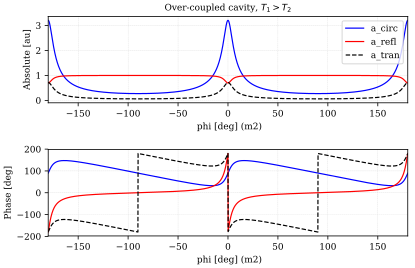

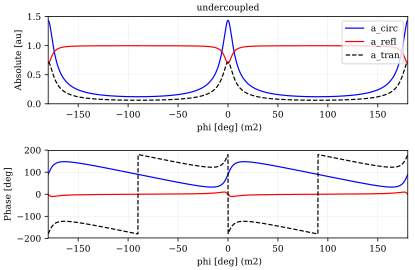

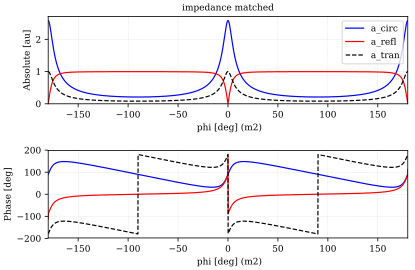

In [8]:
T_tot = 0.3

# Over-coupled, T1 > T2
T1 = 0.25
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2a = kat2.run()

# Under-coupled, T1 < T2
T1 = 0.05
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2b = kat2.run()

# Impedance matched, T1 = T2
T1 = 0.15
T2 = T_tot-T1
R1 = 1-T1
R2 = 1-T2
kat2.m1.T = T1
kat2.m1.R = R1
kat2.m2.T = T2
kat2.m2.R = R2
out2c = kat2.run() 

fig2a = out2a.plot(detectors=['a_circ','a_refl','a_tran'],
                   title = 'Over-coupled cavity, $T_1>T_2$',
                   styles={'a_circ':'b-','a_refl':'r-','a_tran':'k--'})

fig2b = out2b.plot(detectors=['a_circ','a_refl','a_tran'],
                  ylim = (0,None),
                  styles = {'a_circ':'b-','a_refl':'r-','a_tran':'k--'},
                  title = 'undercoupled')
fig2c = out2c.plot(detectors=['a_circ','a_refl','a_tran'],
                  ylim = (0,None),
                  styles = {'a_circ':'b-','a_refl':'r-','a_tran':'k--'},
                  title = 'impedance matched')

In [9]:
kat3 = deepcopy(basekat)
code = """
xaxis laser f lin -5k 90k 1000
yaxis abs
"""
kat3.parse(code)

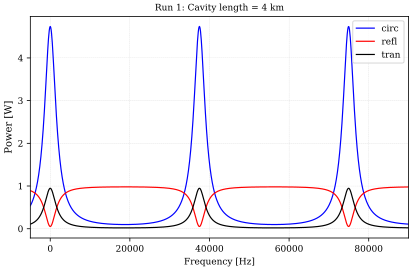

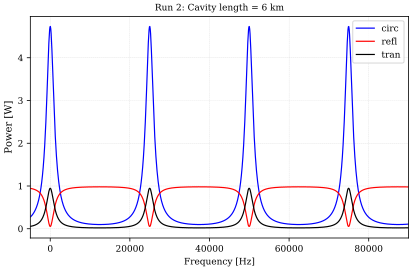

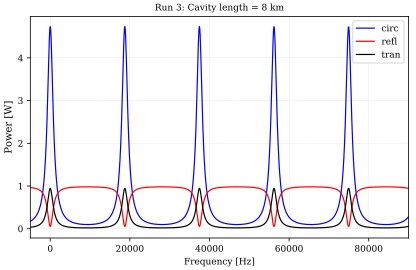

In [10]:
# 1st run, original cavity length of 4 km.
out3a = kat3.run()

# 2nd run, cavity length of 6 km.
kat3.sL.L = 6000
out3b = kat3.run()

# 3rd run, cavity length of 8 km.
kat3.sL.L = 8000
out3c = kat3.run()

# Run 1
fig3a = out3a.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 1: Cavity length = 4 km',
                   loc=1)
# Run 2
fig3b = out3b.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 2: Cavity length = 6 km', 
                   loc=1)
# Run 3
fig3c = out3c.plot(xlabel='Frequency [Hz]', 
                   ylabel='Power [W]', 
                   title='Run 3: Cavity length = 8 km', 
                   loc = 1)

In [11]:
# ignoring optimisation task because it looks pretty tedious

In [12]:
ifobasekat = finesse.kat()

code = """
## Parameters ##
const Pin 1M         # Laser power (1 MW)
const LX 4000        # Length of X arm (4000 m)
const LY 4000        # Length of Y arm (4000 m)

## Laser & Beam splitter ##
l laser $Pin 0 n0                         # Laser
s s1 1 n0 nbsc                            # Space from laser to beam splitter
bs BS 0.5 0.5 0 45 nbsc nbsY nbsX nbsd    # Beam splitter (R = T = 0.5, phi = 0 deg, 
                                          # AoI = 45 deg).
## X arm ##
s LX $LX nbsX nmX1         # Space, BS to mX (4000 m)
m mX 1 0 0 nmX1 nmX2       # Mirror mX (R = 1, T = 0, phi = 0 deg)

## Y arm ##
s LY $LY nbsY nmY1         # Space, BS to mY (4000 m)
m mY 1 0 0 nmY1 nmY2       # Mirror mY (R = 1, T = 0, phi = 0 deg)

## Output port ##
s sout 1 nbsd nout         # Space, BS to output
pd pout nout

"""
# """
# # constants
# const Pin 1M
# const LX 4k
# const LY 4k

# # components
# l laser Pin 0 n1
# s s1 1 n1 nbs1
# bs BS 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4
# s sx LX nbs2 nm1
# m m1 0.9 0.1 0 nm1 nm1o
# s sy LY nbs3 nm2
# m m2 0.9 0.1 0 nm2 nm2o

# # detectors
# pd darkport nbs4
# pd brightport nbs1
# """

ifobasekat.parse(code)

In [13]:
print(ifobasekat.components,ifobasekat.detectors,ifobasekat.constants,sep='\n')

{'laser': <pykat.components.laser_71 (laser) at 0x7fc8ca64edd8>, 's1': <pykat.components.space_72 (s1) at 0x7fc8cca10f60>, 'BS': <pykat.components.beamSplitter_73 (BS) at 0x7fc8ca72ada0>, 'LX': <pykat.components.space_74 (LX) at 0x7fc8ca6ce710>, 'mX': <pykat.components.mirror_75 (mX) at 0x7fc8cca14e80>, 'LY': <pykat.components.space_76 (LY) at 0x7fc8ca8321d0>, 'mY': <pykat.components.mirror_77 (mY) at 0x7fc8cca0dd30>, 'sout': <pykat.components.space_78 (sout) at 0x7fc8ca5bd588>}
{'pout': <pykat.detectors.pykat.detectors.pd_43 object at 0x7fc8ca5bd9b0>}
{}


In [14]:
# differential tuning
kat1 = deepcopy(ifobasekat)
code = """
xaxis mX phi lin -180 180 2000
put* mY phi $mx1
yaxis abs
"""
kat1.parse(code)

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:17.893246
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.062463 seconds


100% | ETA:  0:00:00 | Calculating                                             

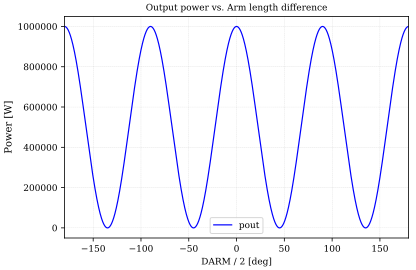

In [15]:
out1 = kat1.run()

fig1 = out1.plot(xlabel="DARM / 2 [deg]", 
                 ylabel="Power [W]", 
                 title="Output power vs. Arm length difference")

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:18.356868
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0652163 seconds


100% | ETA:  0:00:00 | Calculating                                             

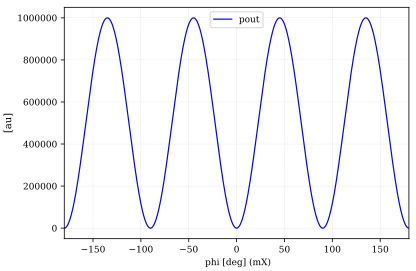

In [16]:
kat2 = deepcopy(kat1)
# changing mX is pointless given xaxis, instead change mY and be sure to use put*
kat2.mY.phi = 90

out2 = kat2.run()
out2.plot()

In [17]:
import scipy.optimize as opt
help(opt.minimize_scalar)

Help on function minimize_scalar in module scipy.optimize._minimize:

minimize_scalar(fun, bracket=None, bounds=None, args=(), method='brent', tol=None, options=None)
    Minimization of scalar function of one variable.
    
    Parameters
    ----------
    fun : callable
        Objective function.
        Scalar function, must return a scalar.
    bracket : sequence, optional
        For methods 'brent' and 'golden', `bracket` defines the bracketing
        interval and can either have three items ``(a, b, c)`` so that
        ``a < b < c`` and ``fun(b) < fun(a), fun(c)`` or two items ``a`` and
        ``c`` which are assumed to be a starting interval for a downhill
        bracket search (see `bracket`); it doesn't always mean that the
        obtained solution will satisfy ``a <= x <= c``.
    bounds : sequence, optional
        For method 'bounded', `bounds` is mandatory and must have two items
        corresponding to the optimization bounds.
    args : tuple, optional
        E

In [18]:
# why not larger than 10mW?
kat3 = deepcopy(kat2)
code = """
noxaxis
"""
kat3.parse(code)
out3 = kat3.run()

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:18.866331
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0132196 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [19]:
# out3.y gives abs at darkport

In [20]:
def darkport(phi):
    kat = deepcopy(kat2)
    kat.noxaxis = True
    kat.mY.phi = phi
    out = kat.run()
    return out.y[0][0]

In [21]:
dp10m = lambda x : darkport(x) - 10e-3

In [22]:
val10m = opt.bisect(dp10m, 0, 90)

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:18.935967
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.011626 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:18.955242
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00946283 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:18.971445
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0100455 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:18.988508
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0108845 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.005855
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0136564 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.083038
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0133007 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.110643
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00973344 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.125881
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00906301 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.140582


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0104005 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.157490
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0141227 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.181803
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.01072 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.201368
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00886011 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.216223
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0086925 seconds
--------------------------------------------------------------
Running kat - Star

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0124154 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.301931
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0146062 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.327085
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00968671 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.344149
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00935292 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.359806
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00989223 seconds
--------------------------------------------------------------
Running kat - 

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00969648 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.505263
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0153737 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.531395
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.010262 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.547719
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.00898027 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.562263
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0112772 seconds
--------------------------------------------------------------
Running kat - St

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0105178 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.705607
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0108643 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.721925
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0105798 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.737875
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0108769 seconds
--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.754362
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0097723 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [23]:
darkport(val10m)

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.775692
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0124626 seconds


100% | ETA:  0:00:00 | Calculating                                             

0.00999999999785177

In [24]:
kat3c = deepcopy(kat3)
kat3c.mY.phi = val10m
out3c = kat3c.run()
print('Pout = {0} mW'.format(1000.0*out3c['pout']))

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.807439
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0132022 seconds
Pout = 9.99999999785177 mW


100% | ETA:  0:00:00 | Calculating                                             

In [25]:
ifobasekat.components

{'BS': <pykat.components.beamSplitter_73 (BS) at 0x7fc8ca72ada0>,
 'LX': <pykat.components.space_74 (LX) at 0x7fc8ca6ce710>,
 'LY': <pykat.components.space_76 (LY) at 0x7fc8ca8321d0>,
 'laser': <pykat.components.laser_71 (laser) at 0x7fc8ca64edd8>,
 'mX': <pykat.components.mirror_75 (mX) at 0x7fc8cca14e80>,
 'mY': <pykat.components.mirror_77 (mY) at 0x7fc8cca0dd30>,
 's1': <pykat.components.space_72 (s1) at 0x7fc8cca10f60>,
 'sout': <pykat.components.space_78 (sout) at 0x7fc8ca5bd588>}

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:19.849970
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0180032 seconds


100% | ETA:  0:00:00 | Calculating                                             

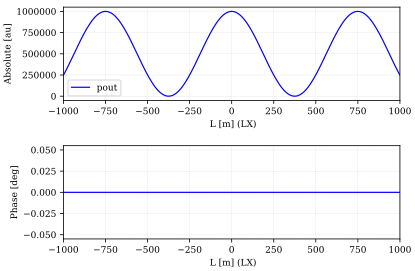

In [26]:
# differential length
kat4 = deepcopy(ifobasekat)
kat4.laser.f = 1e5
code = """
xaxis* LX L lin -1k 1k 200  # * avoids -ve lengths
func yshift = 4000 + $mx1
put* LY L $yshift
noplot yshift
yaxis abs:deg
"""
kat4.parse(code)
out4 = kat4.run()
out4.plot()

In [27]:
# modulation
basekat = finesse.kat()
code= """
## The optical system ##
l laser 1 0 n0                # 1 W laser with 0 offset wavelength
s s1 1 n0 n1                  # Space from laser to mirror (1 m)
mod eom 1k 0.3 5 pm 0 n1 n2   # Modulator (f=1 kHz, m=0.3, 5 sideband pairs, 
                              # phase modulation, 0 degree modulation phase)
s s2 1000 n2 n3               # Space from modulator to output (1 m)
"""
basekat.parse(code)

In [28]:
kat1 = basekat.deepcopy()

code = """
## Detectors ##
ad car 0 n3                   # Ampitude dector, carrier (0 freq offset)
ad up1 1k n3                  # Ampitude dector, first upper sideband (1 kHz offset)
ad up2 2k n3                  # Ampitude dector, second upper sideband (2 kHz offset)
ad up3 3k n3                  # Ampitude dector, third upper sideband (3 kHz offset)
ad up4 4k n3                  # Ampitude dector, fourth upper sideband (4 kHz offset)
ad up5 5k n3                  # Ampitude dector, fourth upper sideband (5 kHz offset)

## Instructions ##
xaxis eom midx lin 0 6 200    # Varying the modulation index between 0 and 1
yaxis abs                   # Showing amplitude detected by amplitude detectors
"""

# Parsing the code and running the simulation
kat1.parseCommands(code)
out1 = kat1.run()

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:20.562439
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0360761 seconds


/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: parseCommands depreciated, use parse.
100% | ETA:  0:00:00 | Calculating                                             

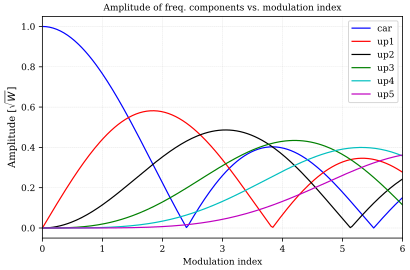

In [29]:
fig1 = out1.plot(title = 'Amplitude of freq. components vs. modulation index', 
                 ylabel='Amplitude $[\sqrt{W}]$',  
                 xlabel='Modulation index')

In [30]:
# Copying our core model
kat2 = basekat.deepcopy()

# Adding detectors and instructions
code = """
## Detectors ##

# Amplitude detectors
ad car 0 n3                   # For the carrier (0 freq offset)
ad up1 1k n3                  # For 1st upper sideband (1 kHz freq offset)
ad low1 -1k n3                # For 1st lower sideband (-1 kHz freq offset)
ad up2 2k n3                  # For 2nd upper sideband (2 kHz freq offset)
ad low2 -2k n3                # For 2nd lower sideband (-2 kHz freq offset)
ad up3 3k n3                  # For 3rd upper sideband (3 kHz freq offset)
ad low3 -3k n3                # For 3rd lower sideband (-3 kHz freq offset)
ad up4 4k n3                  # For 4th upper sideband (4 kHz freq offset)
ad low4 -4k n3                # For 4th lower sideband (-4 kHz freq offset)
ad up5 5k n3                  # For 5th upper sideband (5 kHz freq offset)
ad low5 -5k n3                # For 5th lower sideband (-5 kHz freq offset)

# Photo diode
pd pow n3                     # Detecting DC-power

## Instructions ##
xaxis eom midx lin 0 6 200    # Varying modulation index between 0 and 1
yaxis abs                     # Absolute value of the detector outputs
"""

# Parsing the code and running the simulation
kat2.parseKatCode(code)
out2 = kat2.run()

--------------------------------------------------------------
Running kat - Started at 2020-07-23 16:19:21.052981
Used Finesse 2.3.1 at /home/james/Code/cbrOzGrav/Finesse/kat

Finished in 0.0384765 seconds


/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: UserWarning: parseKatCode depreciated, use parse.
100% | ETA:  0:00:00 | Calculating                                             

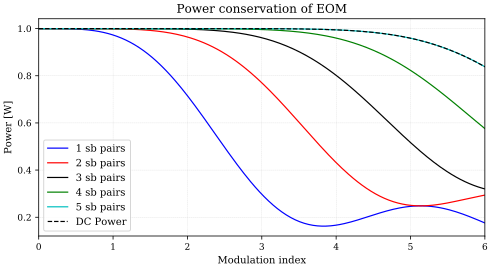

In [31]:
# was missing lower sidebands, plus amplitude isn't conserved, energy is |E|^2
# Computing power
# ---------------
P1 = (out2.y[:,0:3]**2).sum(axis=1)    # With one sideband pair
P2 = (out2.y[:,0:5]**2).sum(axis=1)    # With two sideband pairs
P3 = (out2.y[:,0:7]**2).sum(axis=1)    # With three sideband pairs
P4 = (out2.y[:,0:9]**2).sum(axis=1)    # With four sideband pairs
P5 = (out2.y[:,0:11]**2).sum(axis=1)   # With five sideband pairs

# Plotting
# ---------
fig2 = plt.figure(figsize=(8,4))
ax = plt.subplot(1,1,1)
ax.plot(out2.x, P1, label='1 sb pairs')
ax.plot(out2.x, P2, label='2 sb pairs')
ax.plot(out2.x, P3, label='3 sb pairs')
ax.plot(out2.x, P4, label='4 sb pairs')
ax.plot(out2.x, P5, label='5 sb pairs')
ax.plot(out2.x, out2['pow'],'k--', label='DC Power')
# Labels and legend
ax.set_title('Power conservation of EOM')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Modulation index')
ax.legend(loc=3)
plt.show(fig2)

In [32]:
basekat = finesse.kat()          # Initialising Finesse
basekat.verbose = False          # Tells Finesse to talk less

# Finesse code
code = """
## The optical system ##
l laser 1 0 n0                # 1 W laser, 0 wavelength offset (using default 1064nm)
s s1 1 n0 n1                  # Space from laser to mirror (1 m)
mod eom 1k 0.3 1 am 0 n1 n2   # Modulator (f=1 kHz, m=0.3, 1 sideband pair, 
                              # amplitude modulation, 0 degree mod. phase)
s s2 1000 n2 n3               # Space from modulator to output (1 m)
"""

# Parsing the Finesse code
basekat.parseKatCode(code)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: UserWarning: parseKatCode depreciated, use parse.
  from ipykernel import kernelapp as app


In [33]:
kat1 = deepcopy(basekat)

code = """
## Detectors ##
ad car 0 n3                   # Ampitude dector, carrier (0 freq offset)
ad up1 1k n3                   # Ampitude dector, upper sideband (1 kHz offset)
ad low1 -1k n3                   # Ampitude dector, lower sideband (-1 kHz offset)

pd pow n3                     # Photo diode, detecting DC-power

## Simulation Instructions ##
xaxis eom midx lin 0 1 200   # Varying the modulation index between 0 and 1.
yaxis abs                    # Returns magnitudes of detector outputs
"""

# Parsing the code and running the simulation
kat1.parseCommands(code)
out1 = kat1.run()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: UserWarning: parseCommands depreciated, use parse.


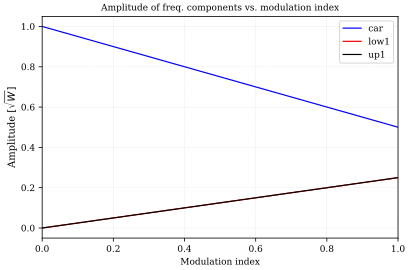

In [34]:
# Only plotting the 
fig1 = out1.plot(detectors=['car','low1','up1'],
                 title = 'Amplitude of freq. components vs. modulation index', 
                 ylabel='Amplitude $[\sqrt{W}]$',  
                 xlabel='Modulation index')

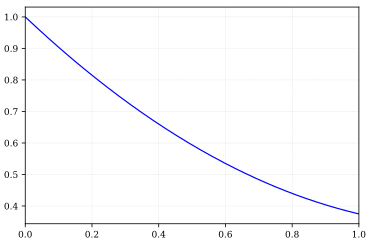

In [35]:
total_energy = (out1.y[:,0:3]**2).sum(axis=1)
plt.plot(out1.x, total_energy)

In [36]:
basekat = finesse.kat()    # Initialising FINESSE
basekat.verbose = False    # Keep quiet

# FINESSE code
code = '''
const freq 10k             # creating a constant for the frequency offset

l laser1 1 0 n1            # laser with P=1W at the default frequency
s s1 1n n1 n2              # space of 1nm length

l laser2 0.1 $freq n3      # a second laser with f=10kHz frequency offset
s s2 1n n3 n4              # another space of 1nm length

bs bs1 0.5 0.5 0 0 n2 n5 dump n4   # 50:50 beam splitter
s s3 1n n5 n6                      # another space of 1nm length
'''
basekat.parse(code)

In [37]:
# Copying basekat
kat = deepcopy(basekat)

# FINESSE code
code = '''
const freq 10k             
## Detectors ##
ad a1 0 n6                        # amplitude detector, default frequency
ad a2 $freq n6                    # amplitude detector, 10 kHz offset
pd dc n6                          # photo didoe, measuring DC-power
pd1 ac $freq n6                   # photo diode + demodulation at 10kHz + 
                                  # + low pass filter

## Simulation instructions ##
xaxis laser2 phi lin 0 180 200     # Sweeping phase of beam from laser2
yaxis abs:deg                      # Returns complex representation of detector outputs
'''

# Running the simulation
kat.parse(code)
out = kat.run()

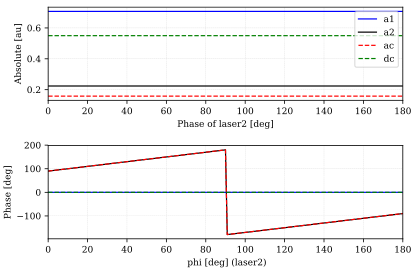

In [38]:
# Setting 
styles={'a1':'b-','a2':'k-','dc':'g--','ac':'r--'}

fig = out.plot(styles = styles, 
               xlabel='Phase of laser2 [deg]',
               loc=1)

In [39]:
# Copying basekat
kat = deepcopy(basekat)

# FINESSE code
code = '''
const freq 10k             
## Detectors ##
ad a1 0 n6                        # amplitude detector, default frequency
ad a2 $freq n6                    # amplitude detector, 10 kHz offset
pd dc n6                          # photo didoe, measuring DC-power
pd1 ac $freq n6                   # photo diode + demodulation at 10kHz + 
                                  # + low pass filter

## Simulation instructions ##
xaxis laser2 P log 1p 1M 2000     # Sweeping phase of beam from laser2
yaxis log abs                     # Returns complex representation of detector outputs

set pow dc abs                    # making output of dc available as variable 
                                  # with name pow.
set ac1 ac abs                    # making output of ac avaiblable as variable 
                                  # with name ac1.
func E2 = $ac1/sqrt($pow+1E-21)   # Recreating amplitude of laser2. 1E-21 is used 
                                  # in denominator to avoid division by zero.
'''

# Running the simulation
kat.parse(code)
out = kat.run()

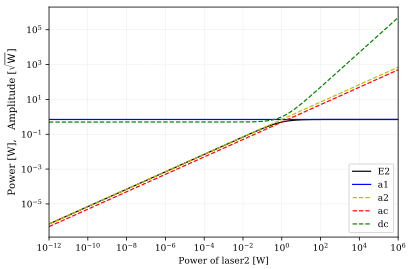

In [40]:
# Setting plotting style for the detectors

# remember that laser 1 is at 1W of power, which gives the crossing point below
style = {'a1':'b-','a2':'y--','dc':'g--','ac':'r--','E2':'k-'}
fig2 = out.plot(styles = style, 
                 xlabel='Power of laser2 [W]', 
                 ylabel='Power [W],   Amplitude [$\sqrt{\mathrm{W}}$]',
                 loc=4)

In [41]:
basekat = finesse.kat()          # Initialising Finesse
basekat.verbose = False          # Tells Finesse to talk less

# Parsing the code
code = """
## The optical system ##
l laser 1 0 n0                               # Laser (Power = 1W, Freq offset = 0 Hz)
s s1 1 n0 nBS1                               # Space, laser to BS (L = 1 m)
bs BS1 0.5 0.5 0 45 nBS1 dump nBS3 nBS4      # Beam splitter (R=T=0.5, phi=0 deg, 
                                             # AoI=45 deg)
s s2 1 nBS3 nM1                              # Space, BS to Mirror (L = 1 m)
m M1 1 0 0 nM1 nM2                           # Mirror (R=1, T=0, phi=0 deg)
s s3 1 nBS4 nOut                             # Space, BS to detectors (L = 1m)

## Shaking the mirror longitudinally ##
fsig sig1 M1 100 0 1                         # Signal (f=100 Hz, phase=0 deg, 
                                             # amplitude=1)
"""
# Parsing FINESSE-code
basekat.parse(code)

In [42]:
kat1 = basekat.deepcopy()
code = """
## Detectors ##

# Amplitude detectors
ad car 0 nOut             # Carrier (Offset = 0 Hz)
ad up1 100 nOut           # 1st upper sideband (Offset = 100 Hz)
ad low1 -100 nOut         # 1st lower sideband (Offset = -100 Hz)
ad up2 200 nOut           # 2nd upper sideband (Offset = 200 Hz)
#ad low2 -200 nOut           


## Simulation instructions ##
xaxis sig1 amp lin 0.01 2 200   # Sweeping amplitude of sig1 between 0.01 and 2. 
yaxis abs
"""

# Parsing FINESSE code and running
kat1.parse(code)
out1 = kat1.run()

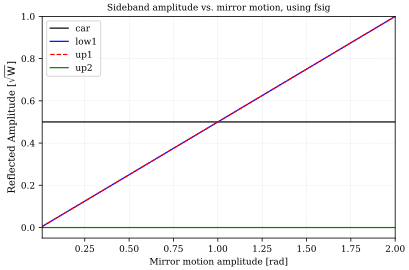

In [43]:
## Plotting ##
# -------------
fig1 = out1.plot(styles={'car': '-k','up1':'--r', 'low1': '-b',  'up2':'g-'},
                 xlabel='Mirror motion amplitude [rad]',
                 ylabel='Reflected Amplitude [$\sqrt{\mathrm{W}}$]',
                 title='Sideband amplitude vs. mirror motion, using fsig', 
                 ylim=(-0.05,1))

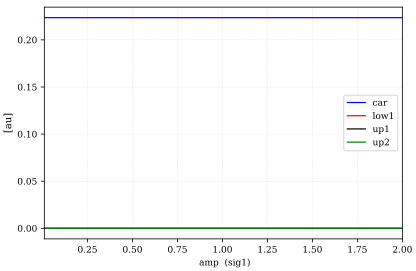

In [44]:
kat2 = deepcopy(basekat)
kat2.M1.R = 0.9
kat2.M1.T = 0.1
code = """
## Detectors ##

# Amplitude detectors
ad car 0 nM2             # Carrier (Offset = 0 Hz)
ad up1 100 nM2           # 1st upper sideband (Offset = 100 Hz)
ad low1 -100 nM2         # 1st lower sideband (Offset = -100 Hz)
ad up2 200 nM2           # 2nd upper sideband (Offset = 200 Hz)
#ad low2 -200 nM2           


## Simulation instructions ##
xaxis sig1 amp lin 0.01 2 200   # Sweeping amplitude of sig1 between 0.01 and 2. 
yaxis abs
"""

# Parsing FINESSE code and running
kat2.parse(code)
out2 = kat2.run()
out2.plot()

In [45]:
basekat = finesse.kat()          # Initialising Finesse
basekat.verbose = False          # Tells Finesse to talk less

basecode = """
## The optical system ##

l laser 1 0 n0                # Laser (P = 1 W, Freq. offset = 0 Hz)
s s1 1 n0 n1                  # Space, laser to EOM (L = 1 m)
mod eom 1k 0.3 1 am 30 n1 n2  # Modulator (f = 1 kHz, m=0.3, 1 sideband pair, 
                              # type = amplitude modulation, phase = 30 deg.)
s s2 1n n2 n3                 # Space, EOM to output (L = 1 nm)

"""
# Parsing the FINESSE-code
basekat.parse(basecode)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: UserWarning: parseCommands depreciated, use parse.


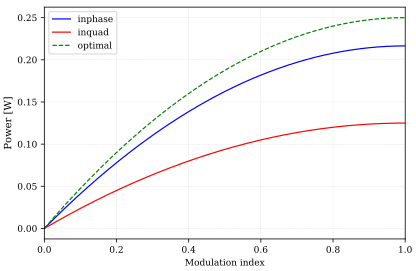

In [46]:
kat1 = basekat.deepcopy()

code = """
## Detectors ##
pd1 inphase 1k 0 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod phase = 0 deg.)
pd1 inquad 1k 90 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod. phase = 90 deg.)
pd1 optimal 1k 30 n3    # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod. phase = 30 deg.)

## Simulation Instructions ##
xaxis eom midx lin 0 1 200   # Varying EOM modulation between 0 and 1
yaxis abs                # Returns absolute values of detector outputs
"""

# Parsing the code and running the simulation
kat1.parseCommands(code)
out1 = kat1.run()

fig1a = out1.plot(xlabel = 'Modulation index',
                  ylabel = 'Power [W]',
                  styles = {'optimal':'g--'})

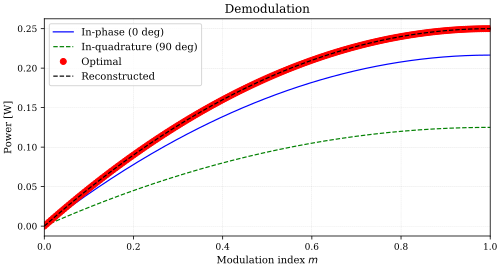

In [47]:
# Reconstructing full amplitude and phase information
tot = out1['inphase'] + 1j*out1['inquad']

## Plotting ##
fig1b = plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
ax.plot(out1.x, out1['inphase'], 'b-', label='In-phase (0 deg)')
ax.plot(out1.x, out1['inquad'], 'g--', label='In-quadrature (90 deg)')
ax.plot(out1.x, out1['optimal'], 'ro', label='Optimal')
ax.plot(out1.x, np.abs(tot), 'k--', label='Reconstructed')

ax.set_xlabel('Modulation index $m$')
ax.set_ylabel('Power [W]')
ax.set_title('Demodulation')
ax.legend(loc=0, fontsize=10)

plt.show()

In [48]:
kat2 = basekat.deepcopy()

code = """
## Detectors ##
pd1 inphase 1k 0 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod phase = 0 deg.)
pd1 inquad 1k 90 n3     # Photodiode + mixer + low pass filter 
                        # (demod. f = 1kHz, demod. phase = 90 deg.)
pd dcpower n3
ad amp 1k n3

## Simulation Instructions ##
xaxis eom midx lin 0 1 200   # Varying EOM modulation between 0 and 1
yaxis abs:deg                # Returns absolute values of detector outputs
"""

# Parsing the code and running the simulation
kat2.parse(code)
out2 = kat2.run()

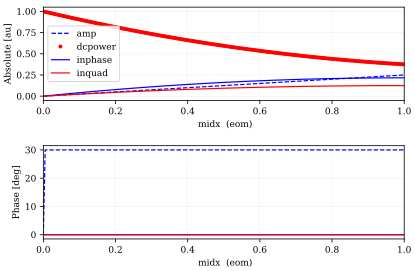

In [49]:
# Reconstructing full amplitude and phase information

out2.plot(styles={'amp':'b--','dcpower':'r.'})

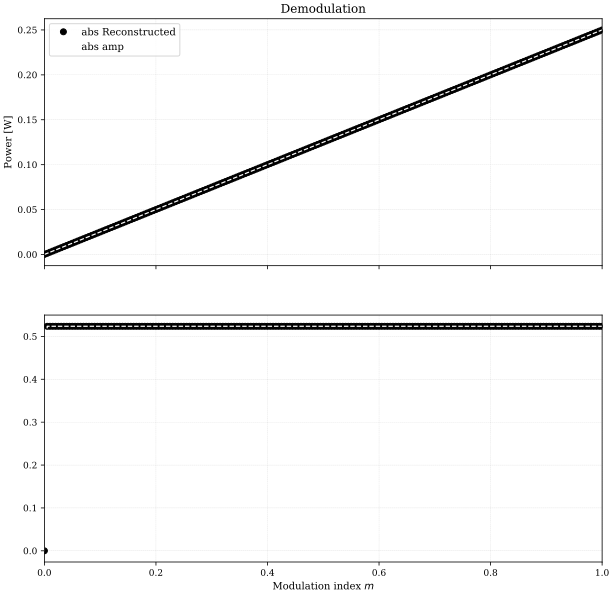

In [50]:
tot = out2['inphase'] + 1j*out2['inquad']

# Calculating the amplitude of the carrier
a0 = np.sqrt( ( out2['dcpower'] + np.sqrt(out2['dcpower']**2 - 2*np.abs(tot)**2) )/2 )

# Calculating complex amplitude of the upper sideband
a_plus = tot/(2*a0)

## Plotting ##
fig2, (ax, ax2) = plt.subplots(2, 1, figsize = (10,10), sharex=True)

# ax.plot(out2.x, out2['inphase'], 'b-', label='In-phase (0 deg)')
# ax.plot(out2.x, out2['inquad'], 'g--', label='In-quadrature (90 deg)')
ax.plot(out2.x, np.abs(a_plus), 'ko', label='abs Reconstructed')
ax.plot(out2.x, np.abs(out2['amp']), 'w--', label='abs amp')

ax2.plot(out2.x, np.angle(a_plus), 'ko', label='phi Reconstructed')
ax2.plot(out2.x, np.angle(out2['amp']), 'w--', label='angle amp')

ax2.set_xlabel('Modulation index $m$')
ax.set_ylabel('Power [W]')
ax.set_title('Demodulation')
ax.legend(loc=0, fontsize=10)

plt.show()

In [51]:
basekat = finesse.kat()          # Initialising Finesse
basekat.verbose = False          # Tells Finesse to talk less

basecode = """
## The optical system ##

l laser 100 0 n0               # Laser (P = 100 W, Freq. offset = 0 Hz)
s s1 1 n0 n1                   # Space, laser to EOM (L = 1 m)
mod eom1 1M 0.5 1 am 20 n1 n2  # Modulator (f = 1 MHz, m=0.5, 1 sideband pair, 
                               # type = amplitude modulation, phase = 20 deg.)
s s2 1 n2 n3                   # Space, eom1 to eom2 (L = 1 m)
mod eom2 1k 0.3 1 am 60 n3 n4  # Modulator (f = 1 kHz, m=0.3, 1 sideband pair, 
                               # type = amplitude modulation, phase = 60 deg.)
s s3 1 n4 n5                   # Space, eom2 to output (L = 1 m)

"""
# Parsing the FINESSE-code
basekat.parse(basecode)

In [52]:
kat1a = basekat.deepcopy()

code = """
## Detectors ##
pd1 inphase 1M 0 n5    # Photodiode + mixer + low pass filter 
                       # (f1 = 1 MHz, phi1 = 0 deg)
pd1 inquad 1M 90 n5    # Photodiode + mixer + low pass filter 
                       # (f1 = 1 MHz, phi1 = 90 deg)

## Simulation Instructions ##
noxaxis                # No xaxis. Computing just one data point.
yaxis abs              # Returns absolute values of detector outputs
"""

# Parsing the code and running the simulation
kat1a.parseCommands(code)
out1a = kat1a.run()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: UserWarning: parseCommands depreciated, use parse.
  app.launch_new_instance()


In [53]:
# Reconstructing full complex demodulation signal
S1 = out1a['inphase'] + 1j*out1a['inquad']
# Calculating the phase
phase1 = np.angle(S1)*180.0/np.pi
print('Optimal demodulation phase at 1 MHz: {:f} deg'.format(phase1))

Optimal demodulation phase at 1 MHz: 17.598339 deg


/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: parseCommands depreciated, use parse.


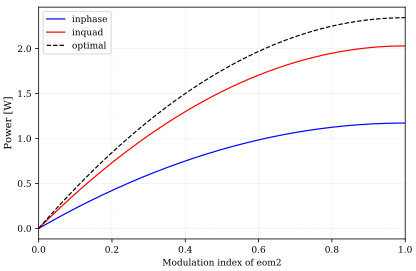

In [54]:
kat1b = basekat.deepcopy()

code = """
## Detectors ##
pd2 inphase 1M {0} 1k 0 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 0 deg)
pd2 inquad 1M {0} 1k 90 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 90 deg)
pd2 optimal 1M {0} 1k max n5   # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = max)

## Simulation Instructions ##
xaxis eom2 midx lin 0 1 200    # Varying EOM modulation between 0 and 1
yaxis abs                      # Returns absolute values of detector outputs
""".format(phase1) #<--- super cool, python wrapper onto Finesse code directly!

# Parsing the code and running the simulation
kat1b.parseCommands(code)
out1b = kat1b.run()
# Plotting the detector outputs
fig1b = out1b.plot(xlabel='Modulation index of eom2', 
                   ylabel='Power [W]',
                   styles={'optimal':'--'})

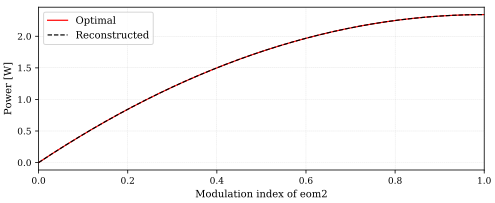

Phase of S2: 59.9988 deg


In [55]:
# Reconstructing
S2 = out1b['inphase'] + 1j*out1b['inquad']

## Plotting ##

# Plotting the the absolute value
fig1c = plt.figure(figsize = (8,3))
ax = plt.subplot(1,1,1)
ax.plot(out1b.x, np.abs(out1b['optimal']), 
        'r-', label='Optimal')
ax.plot(out1b.x, np.abs(S2), 
        'k--', label='Reconstructed')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Modulation index of eom2')
ax.set_title('')
ax.legend(loc=0, fontsize=10)
'''
# Plotting the phase (Converting from radians to degrees)
ax2 = plt.subplot(2,1,2)
ax2.plot(out1b.x, np.angle(out1b['optimal'])*180/np.pi, 'r-', label='Optimal')
ax2.plot(out1b.x, np.angle(S2)*180/np.pi, 'k--', label='Reconstructed')
ax2.set_xlabel('Modulation index of eom2')
ax2.set_ylabel('Phase [deg]')
ax2.set_ylim((0,70))
ax2.legend(loc=0, fontsize=10)
'''
plt.show()

# Calculating and printing the phase of S2 in degrees
phase2 = np.angle(S2[1])*180/np.pi
print('Phase of S2: {:.4f} deg'.format(phase2))

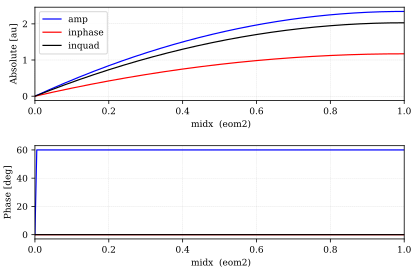

In [56]:
# now that we know the optimal value, we can just use that as phi_x instead of requiring quadrature breakdown
kat2 = basekat.deepcopy()

code = """
## Detectors ##
pd2 inphase 1M {0} 1k 0 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 0 deg)
pd2 inquad 1M {0} 1k 90 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 90 deg)

pd2 amp 1M {0} 1k n5

xaxis eom2 midx lin 0 1 200 
yaxis abs:deg   
""".format(phase1) #<--- super cool, python wrapper onto Finesse code directly!

# Parsing the code and running the simulation
kat2.parse(code)
out2 = kat2.run()
# Plotting the detector outputs
out2.plot()

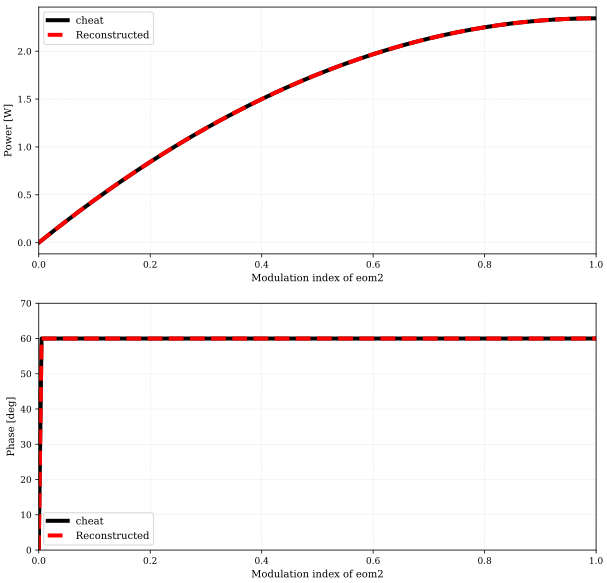

recon. phase of S2: 59.99879916925726774934 deg
 cheat phase of S2: 59.99879916925731038191 deg


In [57]:
# Reconstructing
S2 = out2['inphase'] + 1j*out2['inquad']
cheat = out2['amp']

visA = 'k-'
visB = 'r--'
lw = 4

# Plotting the the absolute value
fig2, (ax, ax2) = plt.subplots(2, 1, figsize = (10,10))

ax.plot(out2.x, np.abs(cheat), 
        visA, label='cheat', linewidth=lw)
ax.plot(out2.x, np.abs(S2), 
        visB, label='Reconstructed', linewidth=lw)
ax.set_ylabel('Power [W]')
ax.set_xlabel('Modulation index of eom2')
ax.set_title('')
ax.legend(loc=0, fontsize=10)

# Plotting the phase (Converting from radians to degrees)
ax2.plot(out1b.x, np.angle(cheat)*180/np.pi, visA, label='cheat', linewidth=lw)
ax2.plot(out1b.x, np.angle(S2)*180/np.pi, visB, label='Reconstructed', linewidth=lw)

ax2.set_xlabel('Modulation index of eom2')
ax2.set_ylabel('Phase [deg]')
ax2.set_ylim((0,70))
ax2.legend(loc=0, fontsize=10)

plt.show()

# Calculating and printing the phase of S2 in degrees
phase2 = np.angle(S2[1])*180/np.pi
phase2_cheat = np.angle(cheat[1])*180/np.pi
print('recon. phase of S2: {0:.20f} deg\n cheat phase of S2: {1:.20f} deg'.format(phase2,phase2_cheat))

In [58]:
# import pykat as pk
# %matplotlib inline

# kat = pk.finesse.kat()
# kat.load('cavity1.kat')
# print(kat.components,kat.detectors,kat.commands)
# print(kat.components['i1'])
# kat.m2.R = 0.9
# kat.m2.T = 0.1

# code = """
# l laser 1 0 n1
# s space 1 n1 n2
# pd pout n2
# xaxis laser P lin 1 10 100
# """

# kat.parse(code)

# out = kat.run()
# out.plot()